<a href="https://colab.research.google.com/github/ebatty/MathToolsforNeuroscience/blob/jupyterbook/Week12/Week12Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1

**Machine Learning IV, Deep Learning**


**[insert your name]**

**Important reminders**: Before starting, click "File -> Save a copy in Drive". Produce a pdf for submission by "File -> Print" and then choose "Save to PDF".

To complete this tutorial, you should have watched Video 12.1, 12.2, and 12.3

**We use the dataset and some of the text/code from NMA W3D4 T1.**


 Imports


In [ ]:
# @markdown Imports

# Imports
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import ipywidgets as widgets  # interactive display
import math
import torch
from torch import nn
from torch import optim


 Plotting functions


In [ ]:
# @markdown Plotting functions
import numpy
from numpy.linalg import inv, eig
from math import ceil
from matplotlib import pyplot, ticker, get_backend, rc
from mpl_toolkits.mplot3d import Axes3D
from itertools import cycle


%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

def plot_data_matrix(X, ax):
  """Visualize data matrix of neural responses using a heatmap

  Args:
    X (torch.Tensor or np.ndarray): matrix of neural responses to visualize
        with a heatmap
    ax (matplotlib axes): where to plot

  """

  cax = ax.imshow(X, cmap=mpl.cm.pink, vmin=np.percentile(X, 1), vmax=np.percentile(X, 99))
  cbar = plt.colorbar(cax, ax=ax, label='normalized neural response')

  ax.set_aspect('auto')
  ax.set_xticks([])
  ax.set_yticks([])


 Data retrieval and loading


In [ ]:
#@markdown Data retrieval and loading
import hashlib
import requests
import os

fname = "W3D4_stringer_oribinned1.npz"
url = "https://osf.io/683xc/download"
expected_md5 = "436599dfd8ebe6019f066c38aed20580"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

 Helper functions


In [ ]:
# @markdown Helper functions

def load_data(data_name=fname, bin_width=1):
  """Load mouse V1 data from Stringer et al. (2019)

  Data from study reported in this preprint:
  https://www.biorxiv.org/content/10.1101/679324v2.abstract

  These data comprise time-averaged responses of ~20,000 neurons
  to ~4,000 stimulus gratings of different orientations, recorded
  through Calcium imaginge. The responses have been normalized by
  spontanous levels of activity and then z-scored over stimuli, so
  expect negative numbers. They have also been binned and averaged
  to each degree of orientation.

  This function returns the relevant data (neural responses and
  stimulus orientations) in a torch.Tensor of data type torch.float32
  in order to match the default data type for nn.Parameters in
  Google Colab.

  This function will actually average responses to stimuli with orientations
  falling within bins specified by the bin_width argument. This helps
  produce individual neural "responses" with smoother and more
  interpretable tuning curves.

  Args:
    bin_width (float): size of stimulus bins over which to average neural
      responses

  Returns:
    resp (torch.Tensor): n_stimuli x n_neurons matrix of neural responses,
        each row contains the responses of each neuron to a given stimulus.
        As mentioned above, neural "response" is actually an average over
        responses to stimuli with similar angles falling within specified bins.
    stimuli: (torch.Tensor): n_stimuli x 1 column vector with orientation
        of each stimulus, in degrees. This is actually the mean orientation
        of all stimuli in each bin.

  """
  with np.load(data_name) as dobj:
    data = dict(**dobj)
  resp = data['resp']
  stimuli = data['stimuli']

  if bin_width > 1:
    # Bin neural responses and stimuli
    bins = np.digitize(stimuli, np.arange(0, 360 + bin_width, bin_width))
    stimuli_binned = np.array([stimuli[bins == i].mean() for i in np.unique(bins)])
    resp_binned = np.array([resp[bins == i, :].mean(0) for i in np.unique(bins)])
  else:
    resp_binned = resp
    stimuli_binned = stimuli

  # Return as torch.Tensor
  resp_tensor = torch.tensor(resp_binned, dtype=torch.float32)
  stimuli_tensor = torch.tensor(stimuli_binned, dtype=torch.float32).unsqueeze(1)  # add singleton dimension to make a column vector

  return resp_tensor, stimuli_tensor

def get_data(n_stim, train_data, train_labels):
  """ Return n_stim randomly drawn stimuli/resp pairs

  Args:
    n_stim (scalar): number of stimuli to draw
    resp (torch.Tensor):
    train_data (torch.Tensor): n_train x n_neurons tensor with neural
      responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians

  Returns:
    (torch.Tensor, torch.Tensor): n_stim x n_neurons tensor of neural responses and n_stim x 1 of orientations respectively
  """
  n_stimuli = train_labels.shape[0]
  istim = np.random.choice(n_stimuli, n_stim)
  r = train_data[istim]  # neural responses to this stimulus
  ori = train_labels[istim]  # true stimulus orientation

  return r, ori

def stimulus_class(ori, n_classes):
  """Get stimulus class from stimulus orientation

  Args:
    ori (torch.Tensor): orientations of stimuli to return classes for
    n_classes (int): total number of classes

  Returns:
    torch.Tensor: 1D tensor with the classes for each stimulus

  """
  bins = np.linspace(0, 360, n_classes + 1)
  return torch.tensor(np.digitize(ori.squeeze(), bins)) - 1  # minus 1 to accomodate Python indexing

def plot_decoded_results(train_loss, test_labels, predicted_test_labels):
  """ Plot decoding results in the form of network training loss and test predictions

  Args:
    train_loss (list): training error over iterations
    test_labels (torch.Tensor): n_test x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians
    predicted_test_labels (torch.Tensor): n_test x 1 tensor with predicted orientations of the
      stimuli from decoding neural network

  """

  # Plot results
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

  # Plot the training loss over iterations of GD
  ax1.plot(train_loss)

  # Plot true stimulus orientation vs. predicted class
  ax2.plot(stimuli_test.squeeze(), predicted_test_labels, '.')

  ax1.set_xlim([0, None])
  ax1.set_ylim([0, None])
  ax1.set_xlabel('iterations of gradient descent')
  ax1.set_ylabel('negative log likelihood')
  ax2.set_xlabel('true stimulus orientation ($^o$)')
  ax2.set_ylabel('decoded orientation bin')
  ax2.set_xticks(np.linspace(0, 360, n_classes + 1))
  ax2.set_yticks(np.arange(n_classes))
  class_bins = [f'{i * 360 / n_classes: .0f}$^o$ - {(i + 1) * 360 / n_classes: .0f}$^o$' for i in range(n_classes)]
  ax2.set_yticklabels(class_bins);

  # Draw bin edges as vertical lines
  ax2.set_ylim(ax2.get_ylim())  # fix y-axis limits
  for i in range(n_classes):
    lower = i * 360 / n_classes
    upper = (i + 1) * 360 / n_classes
    ax2.plot([lower, lower], ax2.get_ylim(), '-', color="0.7", linewidth=1, zorder=-1)
    ax2.plot([upper, upper], ax2.get_ylim(), '-', color="0.7", linewidth=1, zorder=-1)

  plt.tight_layout()


In this tutorial, we'll use deep learning to decode stimulus information from the responses of sensory neurons. Specifically, we'll look at the activity of ~20,000 neurons in mouse primary visual cortex responding to oriented gratings recorded in [this study](https://www.biorxiv.org/content/10.1101/679324v2.abstract). Our task will be to decode the orientation of the presented stimulus from the responses of the whole population of neurons. We could do this in a number of ways, but here we'll use deep learning. Deep learning is particularly well-suited to this problem for a number of reasons:
* The data are very high-dimensional: the neural response to a stimulus is a ~20,000 dimensional vector. Many machine learning techniques fail in such high dimensions, but deep learning actually thrives in this regime, as long as you have enough data (which we do here!).
* As you'll be able to see below, different neurons can respond quite differently to stimuli. This complex pattern of responses will, therefore, require non-linear methods to be decoded, which we can easily do with non-linear activation functions in deep networks.
* Deep learning architectures are highly flexible, meaning we can easily adapt the architecture of our decoding model to optimize decoding. Here, we'll focus on a single architecture, but you'll see that it can easily be modified with few changes to the code.


# Load and visualize data

In the next cell, we have provided code to load the data and plot the matrix of neural responses.

Next to it, we plot the tuning curves of three randomly selected neurons.

## 


 Execute this cell to load and visualize data


23589 neurons in response to 360 stimuli


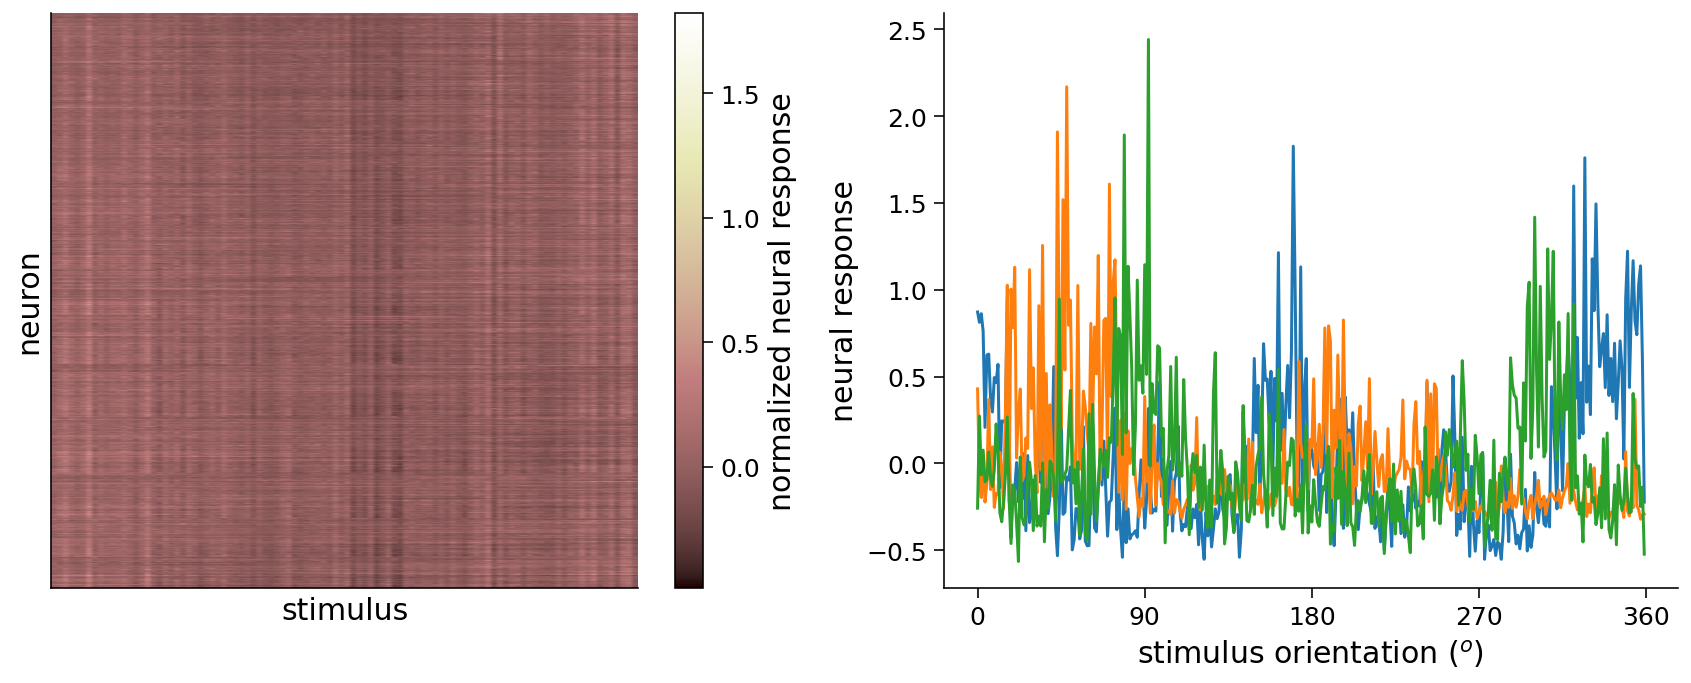

In [ ]:
#@title

#@markdown Execute this cell to load and visualize data

# Load data
resp_all, stimuli_all = load_data()  # argument to this function specifies bin width
n_stimuli, n_neurons = resp_all.shape

print(f'{n_neurons} neurons in response to {n_stimuli} stimuli')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 6, 5))

# Visualize data matrix
plot_data_matrix(resp_all[:100, :].T, ax1)  # plot responses of first 100 neurons
ax1.set_xlabel('stimulus')
ax1.set_ylabel('neuron')

# Plot tuning curves of three random neurons
ineurons = np.random.choice(n_neurons, 3, replace=False)  # pick three random neurons
ax2.plot(stimuli_all, resp_all[:, ineurons])
ax2.set_xlabel('stimulus orientation ($^o$)')
ax2.set_ylabel('neural response')
ax2.set_xticks(np.linspace(0, 360, 5))

plt.tight_layout()

We will split our data into a training set and test set. In particular, we will have a training set of orientations (`stimuli_train`) and the corresponding responses (`resp_train`). Our testing set will have held-out orientations (`stimuli_test`) and the corresponding responses (`resp_test`).

## 


 Execute this cell to split into training and test sets


In [ ]:
#@title
#@markdown Execute this cell to split into training and test sets

# Set random seeds for reproducibility
np.random.seed(4)
torch.manual_seed(4)

# Split data into training set and testing set
n_train = int(0.6 * n_stimuli)  # use 60% of all data for training set
ishuffle = torch.randperm(n_stimuli)
itrain = ishuffle[:n_train]  # indices of data samples to include in training set
itest = ishuffle[n_train:]  # indices of data samples to include in testing set
stimuli_test = stimuli_all[itest]
resp_test = resp_all[itest]
stimuli_train = stimuli_all[itrain]
resp_train = resp_all[itrain]

# Building a deep feedforward network

We'll now build a simple deep neural network that takes as input a vector of neural responses and outputs a single number representing the decoded stimulus orientation.

To keep things simple, we'll build a deep network with **one** hidden layer. See the appendix for a deeper discussion of what this choice entails, and when one might want to use deeper/shallower and wider/narrower architectures.

## Introduction to PyTorch

Here, we'll use the **PyTorch** package to build, run, and train deep networks of this form in Python. There are two core components to the PyTorch package: 

1. The first is the `torch.Tensor` data type used in PyTorch. `torch.Tensor`'s are effectively just like a `numpy` arrays, except that they have some important attributes and methods needed for automatic differentiation (to be discussed below). They also come along with infrastructure for easily storing and computing with them on GPU's, a capability we won't touch on here but which can be really useful in practice.

2. The second core ingredient is the PyTorch `nn.Module` class. This is the class we'll use for constructing deep networks, so that we can then easily train them using built-in PyTorch functions. Keep in my mind that `nn.Module` classes can actually be used to build, run, and train any model -- not just deep networks!

  The next cell contains code for building the deep network we defined above using the `nn.Module` class. It contains three key ingredients:

  * `__init__()` method to initialize its parameters, like in any other Python class. In this case, it takes two arguments:
    * `n_inputs`: the number of input units. This should always be set to the number of neurons whose activities are being decoded (i.e. the dimensionality of the input to the network). 
    * `n_hidden`: the number of hidden units. This is a parameter that we are free to vary in deciding how to build our network. See the appendix for a discussion of how this architectural choice affects the computations the network can perform.

  * `nn.Linear` modules, which are built-in PyTorch classes containing all the weights and biases for a given network layer (documentation [here](https://pytorch.org/docs/master/generated/torch.nn.Linear.html)). This class takes two arguments to initialize:
    * \# of inputs to that layer
    * \# of outputs from that layer

    For the input layer, for example, we have:
    * \# of inputs = \# of neurons whose responses are to be decoded ($N$, specified by `n_inputs`)
    * \# of outputs = \# of hidden layer units ($M$, specified by `n_hidden`)
    
    PyTorch will initialize all weights and biases randomly.

  * `forward()` method, which takes as argument an input to the network and returns the network output. In our case, this comprises computing the output $y$ from a given input $\mathbf{r}$ using the above two equations. See the next cell for code implementing this computation using the built-in PyTorch `nn.Linear` classes.

In [ ]:
class DeepNet(nn.Module):
  """Deep Network with one hidden layer

  Args:
    n_inputs (int): number of input units
    n_hidden (int): number of units in hidden layer

  Attributes:
    in_layer (nn.Linear): weights and biases of input layer
    out_layer (nn.Linear): weights and biases of output layer

  """

  def __init__(self, n_inputs, n_hidden):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(n_inputs, n_hidden) # neural activity --> hidden units
    self.out_layer = nn.Linear(n_hidden, 1) # hidden units --> output

  def forward(self, r):
    """Decode stimulus orientation from neural responses

    Args:
      r (torch.Tensor): vector of neural responses to decode, must be of
        length n_inputs. Can also be a tensor of shape n_stimuli x n_inputs,
        containing n_stimuli vectors of neural responses

    Returns:
      torch.Tensor: network outputs for each input provided in r. If
        r is a vector, then y is a 1D tensor of length 1. If r is a 2D
        tensor then y is a 2D tensor of shape n_stimuli x 1.

    """
    h = self.in_layer(r)  # hidden representation
    y = self.out_layer(h)
    return y

The next cell contains code for initializing and running this network. We use it to decode stimulus orientation from a vector of neural responses to the very first stimulus. Note that when the initialized network class is called as a function on an input (e.g. `net(r)`), its `.forward()` method is called. This is a special property of the `nn.Module` class.

Note that the decoded orientations at this point will be nonsense, since the network has been initialized with random weights. Below, we'll learn how to optimize these weights for good stimulus decoding.

In [ ]:
# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Initialize a deep network with M=200 hidden units
net = DeepNet(n_neurons, 200)

# Get neural responses (r) to and orientation (ori) to one stimulus in dataset
r, ori = get_data(1, resp_train, stimuli_train)  # using helper function get_data

# Decode orientation from these neural responses using initialized network
out = net(r)  # compute output from network, equivalent to net.forward(r)

print('decoded orientation: %.2f degrees' % out)
print('true orientation: %.2f degrees' % ori)

decoded orientation: 0.08 degrees
true orientation: 139.00 degrees


In [ ]:
net.forward(r)

tensor([[0.0758]], grad_fn=<AddmmBackward0>)

## Exercise 1

We do not have any nonlinear activation functions in our deep network above. We want to use the rectified linear activation function, which can be implemented in PyTorch using `torch.relu()`. Hidden layers with this activation function are typically referred to as "**Re**ctified **L**inear **U**nits", or **ReLU**'s.

Initialize this network with 20 hidden units and run on an example stimulus.

**Hint**: you only need to modify the `forward()` method of the above `DeepNet()` class.

In [ ]:
class DeepNetReLU(nn.Module):

  def __init__(self, n_inputs, n_hidden):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(n_inputs, n_hidden) # neural activity --> hidden units
    self.out_layer = nn.Linear(n_hidden, 1) # hidden units --> output

  def forward(self, r):

    ############################################################################
    ## TO DO for students: write code for computing network output using a
    ## rectified linear activation function for the hidden units
    # Fill out function and remove
    raise NotImplementedError("Student exercise: complete DeepNetReLU forward")
    ############################################################################

    h = ...
    y = ...

    return y


# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Get neural responses (r) to and orientation (ori) to one stimulus in dataset
r, ori = get_data(1, resp_train, stimuli_train)

# Initialize deep network with M=20 hidden units and uncomment lines below
net = DeepNetReLU(...)

# Decode orientation from these neural responses using initialized network
# net(r) is equivalent to net.forward(r)
out = net(r)

# print('decoded orientation: %.2f degrees' % out)
print('true orientation: %.2f degrees' % ori)

# Loss function

We will train our model using mean squared error as our loss function. 

PyTorch actually carries with it a number of built-in loss functions. The one corresponding to the squared error is called `nn.MSELoss()`. This will take as arguments a **batch** of network outputs $y_1, y_2, \ldots, y_P$ and corresponding target outputs $\tilde{y}_1, \tilde{y}_2, \ldots, \tilde{y}_P$, and compute the **mean squared error (MSE)**
\begin{equation}
    L = \frac{1}{P}\sum_{n=1}^P \left(y^{(n)} - \tilde{y}^{(n)}\right)^2
\end{equation}

## Exercise 2

Evaluate the mean squared error for a deep network with $M=20$ rectified linear units, on the decoded orientations from neural responses to 20 random stimuli.

In [ ]:
# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Initialize a deep network with M=20 hidden units
net = DeepNetReLU(n_neurons, 20)

# Get neural responses to first 20 stimuli in the data set
r, ori = get_data(20, resp_train, stimuli_train)

# Decode orientation from these neural responses
out = net(r)

###################################################
## TO DO for students: evaluate mean squared error
###################################################

# Initialize PyTorch mean squared error loss function (Hint: look at nn.MSELoss)
loss_fn = ...

# Evaluate mean squared error
loss = ...

print('mean squared error: %.2f' % loss)

# Gradient descent

Let's train our model using stochastic gradient descent. We want to set up code similar to the pseudocode in Video 12.2 at 10.09 min.


We want to update the network weights by descending the gradient. In Pytorch, we can do this using built-in optimizers. We'll use the `optim.SGD` optimizer (documentation [here](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)) which updates parameters along the negative gradient, scaled by a learning rate. To initialize this optimizer, we have to tell it
  * which parameters to update, and
  * what learning rate to use

  For example, to optimize *all* the parameters of a network `net` using a learning rate of .001, the optimizer would be initialized as follows
  ```
  optimizer = optim.SGD(net.parameters(), lr=.001)
  ```
  where `.parameters()` is a method of the `nn.Module` class that returns a [Python generator object](https://wiki.python.org/moin/Generators) over all the parameters of that `nn.Module` class (in our case, $\mathbf{W}^{in}, \mathbf{b}^{in}, \mathbf{W}^{out}, \mathbf{b}^{out}$).



For a single step of gradient descent, our code should look like this:

```
Get outputs from network
Evaluate loss
 
# Compute gradients
optimizer.zero_grad()  # clear gradients
loss.backward()
 
# Update weights
optimizer.step()
```

`loss.backward()` computes the gradient of the loss with respect to each of the network weights. This command tells PyTorch to compute the gradients of the quantity stored in the variable `loss` with respect to each network parameter using [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation). These gradients are then stored behind the scenes. 


`optimizer.step()` uses these gradients to take a step and update the parameters.

`optimizer.zero_grad()` clears the gradients of each parameter. The gradients of each parameter need to be cleared before calling `.backward()`, or else PyTorch will try to accumulate gradients across iterations. 

## Exercise 3

**Write out training code to perform stochastic gradient descent over 50 epochs** using the pseudocode in Video 12.2 at 10.09 min (detailed in code comments below) and the guidance above for what to do for a single step of gradient descent. Then **plot the training loss over gradient descent step or epoch**

I set things up for you in the next cell.

Let's use a minibatch size of 18. You can get a minibatch by doing `stimuli_train[i_batch*18:(i_batch+1)*18]` and `resp_train[i_batch*18:(i_batch+1)*18]`



In [ ]:
# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Initialize network
net = DeepNetReLU(n_neurons, 20)

# Initialize built-in PyTorch MSE loss function
loss_fn = nn.MSELoss()

# Initialize PyTorch SGD optimizer
optimizer = optim.SGD(net.parameters(), lr = 0.0001)


In [ ]:
# your code here

# for each pass of the data (epoch)

  # for each minibatch

    # Take a gradient descent step (compute gradients/update parameters)

    # Record loss function



In [ ]:
# Plot training loss over gradient descent step or epoch (which ever you prefer)



# Evaluating performance

We will compute the MSE on the test data and plot the decoded stimulus orientations as a function of the true stimulus.

## 


 Execute this cell to evaluate and plot test error


In [ ]:
#@title
#@markdown Execute this cell to evaluate and plot test error

out = net(resp_test)  # decode stimulus orientation for neural responses in testing set
ori = stimuli_test  # true stimulus orientations
test_loss = loss_fn(out, ori)  # MSE on testing set (Hint: use loss_fn initialized in previous exercise)

plt.plot(ori, out.detach(), '.')  # N.B. need to use .detach() to pass network output into plt.plot()
#identityLine()  # draw the identity line y=x; deviations from this indicate bad decoding!
plt.title('MSE on testing set: %.2f' % test_loss.item())  # N.B. need to use .item() to turn test_loss into a scalar
plt.xlabel('true stimulus orientation ($^o$)')
plt.ylabel('decoded stimulus orientation ($^o$)')
axticks = np.linspace(0, 360, 5)
plt.xticks(axticks)
plt.yticks(axticks)
plt.show()

**PyTorch Note**:

An important thing to note in the code snippet for plotting the decoded orientations is the `.detach()` method. The PyTorch `nn.Module` class is special in that, behind the scenes, each of the variables inside it are linked to each other in a computational graph, for the purposes of automatic differentiation (the algorithm used in `.backward()` to compute gradients). As a result, if you want to do anything that is not a `torch` operation to the parameters or outputs of an `nn.Module` class, you'll need to first "detach" it from its computational graph. This is what the `.detach()` method does. In this hidden code above, we need to call it on the outputs of the network so that we can plot them with the `plt.plot()` function.

---
# Appendix

## Neural network *depth*, *width* and *expressivity*

Two important architectural choices that always have to be made when constructing deep feed-forward networks like those used here are
* the number of hidden layers, or the network's *depth*
* the number of units in each layer, or the layer *widths*

Here, we restricted ourselves to networks with a single hidden layer with a width of $M$ units, but it is easy to see how this code could be adapted to arbitrary depths. Adding another hidden layer simply requires adding another `nn.Linear` module to the `__init__()` method and incorporating it into the `.forward()` method.

The depth and width of a network determine the set of input/output transormations that it can perform, often referred to as its *expressivity*. The deeper and wider the network, the more *expressive* it is; that is, the larger the class of input/output transformations it can compute. In fact, it turns out that an infinitely wide *or* infinitely deep networks can in principle [compute (almost) *any* input/output transformation](https://en.wikipedia.org/wiki/Universal_approximation_theorem).

A classic mathematical demonstration of the power of depth is given by the so-called [XOR problem](https://medium.com/@jayeshbahire/the-xor-problem-in-neural-networks-50006411840b#:~:text=The%20XOr%2C%20or%20%E2%80%9Cexclusive%20or,value%20if%20they%20are%20equal.). This toy problem demonstrates how even a single hidden layer can drastically expand the set of input/output transformations a network can perform, relative to a shallow network with no hidden layers. The key intuition is that the hidden layer allows you to represent the input in a new format, which can then allow you to do almost anything you want with it. The *wider* this hidden layer, the more flexibility you have in this representation. In particular, if you have more hidden units than input units, then the hidden layer representation of the input is higher-dimensional than the raw data representation. This higher dimensionality effectively gives you more "room" to perform arbitrary computations in. It turns out that even with just this one hidden layer, if you make it wide enough you can actually approximate any input/output transformation you want. See [here](http://neuralnetworksanddeeplearning.com/chap4.html) for a neat visual demonstration of this.

In practice, however, it turns out that increasing depth seems to grant more expressivity with fewer units than increasing width does (for reasons that are not well understood). It is for this reason that truly *deep* networks are almost always used in machine learning, which is why this set of techniques is often referred to as *deep* learning.

That said, there is a cost to making networks deeper and wider. The bigger your network, the more parameters (i.e. weights and biases) it has, which need to be optimized! The extra expressivity afforded by higher width and/or depth thus carries with it (at least) two problems:
* optimizing more parameters usually requires more data
* a more highly parameterized network is more prone to overfit to the training data, so requires more sophisticated optimization algorithms to ensure generalization